In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import os


In [21]:
df = pd.read_csv('/Users/test/Desktop/ML_project/Machine-Learning-Final-Project/Data/Processed/renttherunway_clean.csv')

In [22]:
df.describe()

,user_id,item_id,fit_label,height_inches,weight_lbs,bmi,bust_band,cup_size_num,size,age,body_type_num,rented_for_num,rating,review_year,review_month
count,192544.000000,1.925440e+05,192544.000000,191867.000000,162562.000000,162118.000000,174133.000000,174133.000000,192544.000000,191584.000000,177907.000000,192534.000000,192462.000000,192544.000000,192544.000000
mean,499494.100149,1.045684e+06,0.994432,65.310621,137.391709,22.670947,34.201271,2.958239,12.245175,33.871017,2.964318,4.339935,9.092371,2015.687786,6.851727
std,289059.719328,8.053148e+05,0.512031,2.663480,21.899967,3.380015,1.745246,1.158004,8.494877,8.058083,1.636881,2.498000,1.430044,1.335570,3.380067
min,9.000000,1.233730e+05,0.000000,54.000000,50.000000,8.069330,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2010.000000,1.000000
25%,250654.250000,1.950760e+05,1.000000,63.000000,123.000000,20.372405,34.000000,2.000000,8.000000,29.000000,1.000000,2.000000,8.000000,2015.000000,4.000000
50%,499419.000000,9.483960e+05,1.000000,65.000000,135.000000,21.968750,34.000000,3.000000,12.000000,32.000000,3.000000,4.000000,10.000000,2016.000000,7.000000
75%,750974.000000,1.678888e+06,1.000000,67.000000,148.000000,24.126627,36.000000,4.000000,16.000000,37.000000,4.000000,7.000000,10.000000,2017.000000,10.000000
max,999997.000000,2.966087e+06,2.000000,78.000000,300.000000,54.527435,48.000000,10.000000,58.000000,117.000000,6.000000,8.000000,10.000000,2018.000000,12.000000


In [23]:
print(df.isnull().sum())

user_id                0
item_id                0
fit                    0
fit_label              0
height_inches        677
weight_lbs         29982
bmi                30426
bust_band          18411
cup_size_letter    18411
cup_size_num       18411
size                   0
age                  960
category               0
body_type          14637
body_type_num      14637
rented_for            10
rented_for_num        10
rating                82
review_summary       347
review_text           68
review_date            0
review_year            0
review_month           0
dtype: int64


# fit target: whether it's small, fits, large

In [24]:
body_features = [
    'height_inches', 'weight_lbs', 'bmi',
    'bust_band', 'cup_size_num', 'body_type_num', 'age'
]

df_body = df[body_features].copy()

In [25]:
df_body_clean = df_body.dropna()
print(f"Rows retained: {len(df_body_clean):,} / {len(df_body):,} ({len(df_body_clean)/len(df_body):.1%})")


Rows retained: 146,438 / 192,544 (76.1%)


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_body_clean)

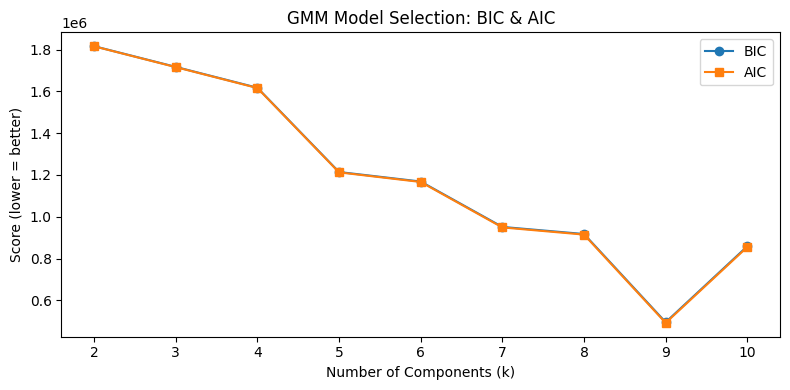

In [27]:
bic_scores = []
aic_scores = []
k_range = range(2, 11)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full',
                          random_state=42, n_init=3)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))


# Set your figure folder path here
fig_folder = "/Users/test/Desktop/ML_project/Machine-Learning-Final-Project/figures"  

# Create folder if it doesn't exist
os.makedirs(fig_folder, exist_ok=True)

plt.show()
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(k_range, bic_scores, marker='o', label='BIC')
ax.plot(k_range, aic_scores, marker='s', label='AIC')
ax.set_xlabel('Number of Components (k)')
ax.set_ylabel('Score (lower = better)')
ax.set_title('GMM Model Selection: BIC & AIC')
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(fig_folder, "gmm_bic_aic.png"), dpi=150, bbox_inches='tight')

In [28]:
k_optimal = 5

gmm_final = GaussianMixture(
    n_components=k_optimal,
    covariance_type='full',
    random_state=42,
    n_init=5
)
gmm_final.fit(X_scaled)

GaussianMixture(n_components=5, n_init=5, random_state=42)

In [29]:
# ── 6. ASSIGN CLUSTERS + SOFT PROBABILITIES ───────────────────────────────────
df_body_clean = df_body_clean.copy()
df_body_clean['body_cluster']       = gmm_final.predict(X_scaled)
df_body_clean['cluster_confidence'] = gmm_final.predict_proba(X_scaled).max(axis=1)

# Drop columns if they already exist (from a previous run)
df = df.drop(columns=['body_cluster', 'cluster_confidence'], errors='ignore')

# # Merge clusters back to original df on index
df = df.join(df_body_clean[['body_cluster', 'cluster_confidence']])
print(df.head())
# # ── 7. PROFILE EACH CLUSTER ───────────────────────────────────────────────────
cluster_profiles = df_body_clean.groupby('body_cluster')[body_features].median()
print(cluster_profiles)

   user_id  item_id  fit  fit_label  height_inches  weight_lbs        bmi  \
0   420272  2260466  fit          1           68.0       137.0  20.828503   
1   273551   153475  fit          1           66.0       132.0  21.303030   
2   360448  1063761  fit          1           64.0         NaN        NaN   
3   909926   126335  fit          1           65.0       135.0  22.462722   
4   151944   616682  fit          1           69.0       145.0  21.410418   

   bust_band cup_size_letter  cup_size_num  ...     rented_for  \
0       34.0               d           4.0  ...       vacation   
1       34.0               b           2.0  ...          other   
2        NaN             NaN           NaN  ...          party   
3       34.0               c           3.0  ...  formal affair   
4       34.0               b           2.0  ...        wedding   

   rented_for_num rating                                     review_summary  \
0             6.0   10.0                               So man

In [31]:
cluster_profiles.shape

(5, 7)

In [30]:
df.to_csv(
    "../Data/Processed/gmm_df.csv",
    index=False
)

In [32]:
cluster_profiles.to_csv(
    "../Data/Processed/gmm_cluster_profiles.csv",
    index=True
)

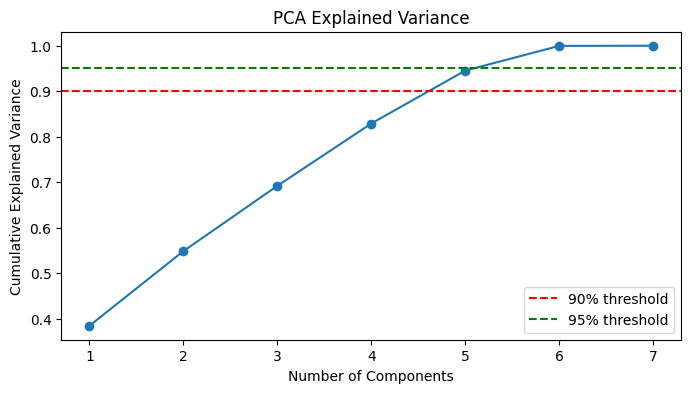

In [33]:
from sklearn.decomposition import PCA

# Fit PCA with all components first
pca_full = PCA()
pca_full.fit(X_scaled)

# Plot explained variance
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.show()
fig.savefig(os.path.join(fig_folder, "PCA_gmm_variance.png"), dpi=150, bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


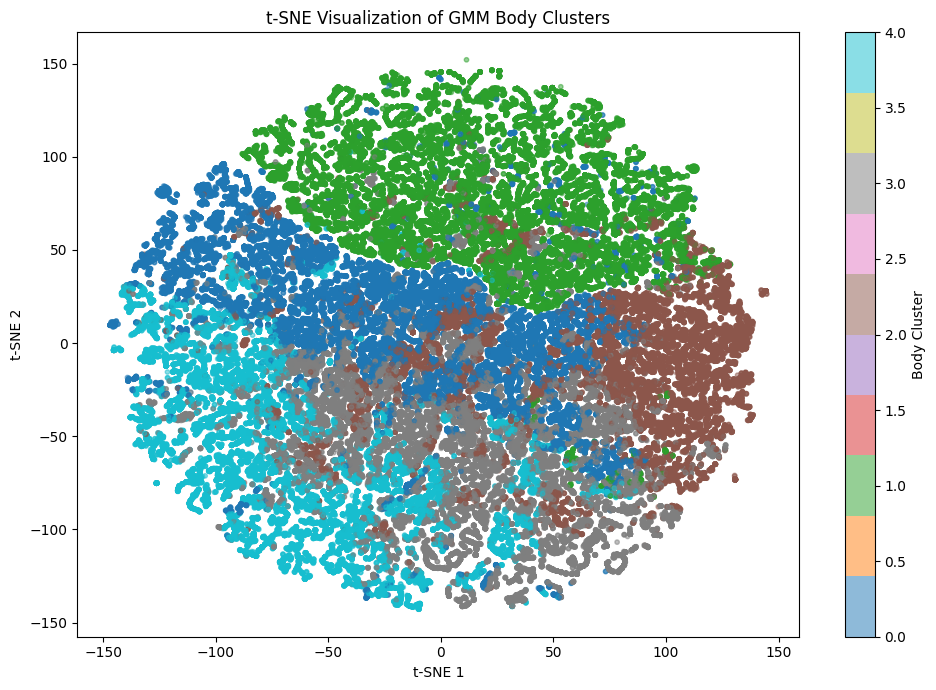

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA first (fast, use to reduce to 2D for t-SNE input)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# t-SNE on PCA output 
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Plot colored by GMM cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                      c=df_body_clean['body_cluster'], 
                      cmap='tab10', alpha=0.5, s=10)
plt.colorbar(scatter, label='Body Cluster')
plt.title('t-SNE Visualization of GMM Body Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "tsne_gmm_clusters.png"), dpi=150, bbox_inches='tight')
plt.show()

In [35]:
X_tsne_df = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
X_tsne_df.to_csv(
    "../Data/Processed/gmm_pca_tsne.csv",
    index=False
)